In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib  as mpl
from tqdm import tqdm
import pickle
import lzma
import time
import os

import numpy as np

from DimensionReduction import Grassmann, DiffusionMaps
from GDMaps_PCE_GSA import *

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

plt.rc("text", usetex=False)    
plt.rc("font", family="serif")

In [2]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(combinations(list(coord), 2))
    comb2 = list(combinations([i for i in range(coord.shape[0])], 2))

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()
        
        
def plot_dm_parsim_coord_multi_level(coords, gs):
    
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    titles = ["Micro-Level Diffusion Coordinates",
              "Meso-Level Diffusion Coordinates",
              "Global-Level Diffusion Coordinates"]
    
    for k, coord in enumerate(coords):
        comb1 = list(combinations(list(coord), 2))
        comb2 = list(combinations([i for i in range(coord.shape[0])], 2))
        
        g = gs[k]

        for i in range(len(comb1)):
            axs[k][i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            axs[k][i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            axs[k][i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            axs[k][i].grid('True')
            axs[k][i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))  
        
        axs[k][1].set_title(titles[k], fontsize=20, y=1.2)
    
    fig.tight_layout()
    plt.savefig("diffusion_coordinates.pdf", bbox_inches="tight")
    plt.show()


def run_GDMaps(p, 
               data, 
               num_runs=10, 
               n_keep=3, 
               parsim=True):
    
    evals_diff_runs  = []
    evecs_diff_runs  = []
    coord_diff_runs = []
    g_diff_runs = []
    residuals_diff_runs = []
    index_diff_runs = []
    
    for i in range(num_runs):
        print('Run: ', i)
        data_all = data[i]

        # Perform GDMAps
        start_time = time.time()
        
        if parsim:
            g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data_all, 
                                                                     n_evecs=20,
                                                                     n_keep=n_keep,
                                                                     parsim=parsim,
                                                                     p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
            residuals_diff_runs.append(residuals)
            index_diff_runs.append(index)
            
        else:
            g, coord, Grass, evals, evecs = GDMaps(data=data_all, 
                                                   n_evecs=20,
                                                   n_keep=n_keep,
                                                   parsim=parsim,
                                                   p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
        
        print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    return (evals_diff_runs, evecs_diff_runs, coord_diff_runs, g_diff_runs,
            residuals_diff_runs, index_diff_runs)

# Testing

In [5]:
NUM_PARAMS = 8192
NUM_REPS = 20
PATH = "W_arrays_debt"
out_path = "../GDMaps_results_debt"

### Micro

In [6]:
DATA = np.zeros((NUM_REPS, NUM_PARAMS, 350, 350), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir(f"../{PATH}/"))):
    data = pickle.load(lzma.open(f"../{PATH}/{f}"))
    # drop last time step
    data = data[:,:,:100].reshape(NUM_PARAMS, 350, 350)
    DATA[i] = data

20it [14:29, 43.47s/it]


In [ ]:
ranks = []
num_runs = 20

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

### Macro

In [111]:
DATA = np.zeros((NUM_REPS, NUM_PARAMS, 10, 10), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir(f"../{PATH}/"))):
    data = pickle.load(lzma.open(f"../{PATH}/{f}"))
    data = np.nan_to_num(data, nan=0, posinf=0, neginf=0) 
    assert np.sum(np.isnan(data)) == 0
    data = np.mean(data, axis=1)[:,:100].reshape(1, NUM_PARAMS, 10, 10)
    DATA[i] = data

0it [00:00, ?it/s]

0


1it [00:49, 49.62s/it]

0


2it [01:37, 48.82s/it]

0


3it [02:27, 49.23s/it]

0


4it [03:18, 49.75s/it]

0


5it [04:07, 49.70s/it]

0


6it [04:57, 49.59s/it]

0


7it [05:45, 49.34s/it]

73


8it [06:35, 49.37s/it]

0


9it [07:24, 49.27s/it]

0


10it [08:13, 49.08s/it]

0


11it [09:04, 49.78s/it]

0


12it [09:52, 49.37s/it]

0


13it [10:44, 49.94s/it]

37


14it [11:33, 49.88s/it]

0


15it [12:24, 50.11s/it]

0


16it [13:13, 49.85s/it]

147


17it [14:04, 49.98s/it]

0


18it [14:54, 50.17s/it]

23


19it [15:45, 50.38s/it]

0


20it [16:34, 49.74s/it]


In [43]:
# asdf = pickle.load(lzma.open(f"../{PATH}/6_debt.pkl.lzma"))

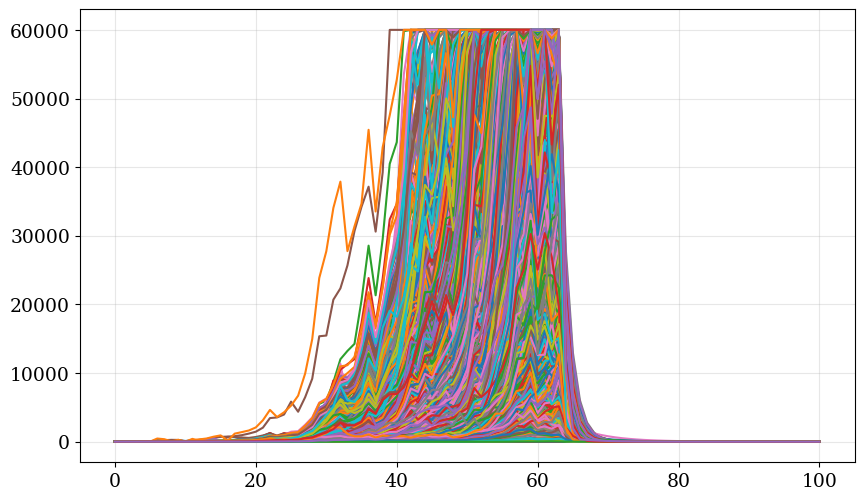

In [112]:
plt.plot(asdf[5053].T)
plt.show()

In [113]:
ranks = []

for run in tqdm(range(NUM_REPS)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.62it/s]

Ranks: 
 [[    1    69]
 [    2 26973]
 [    3 82568]
 [    4 19930]
 [    5  5465]
 [    6  2695]
 [    7  1714]
 [    8   973]
 [    9  1037]
 [   10 22416]]


# Run micro level GDMaps

In [ ]:
p_micro = 30
for i,f in enumerate(os.listdir(f"{PATH}")):
    seed = int(f.split("_")[0])
    data = pickle.load(lzma.open(f"{PATH}/{f}"))
    data = data[:,:,:50].reshape(1, 8192, 250, 250)
    results = run_GDMaps(p=p_micro, data=data, num_runs=1)
    with open(f"{out_path}/micro_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

# Run macro level GDMaps

In [6]:
p_global = 3

DATA = np.zeros((NUM_REPS, NUM_PARAMS, 10, 10), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir(f"../{PATH}/"))):
    seed = int(f.split("_")[0])
    if f"macro_{seed}.pickle" in os.listdir(out_path):
        continuet
    data = pickle.load(lzma.open(f"../{PATH}/{f}"))
    data = np.nan_to_num(data, nan=0, posinf=0, neginf=0) 
    data = np.mean(data, axis=1)[:,:100].reshape(1, NUM_PARAMS, 10, 10)
    results = run_GDMaps(p=p_global, data=data, num_runs=1)
    with open(f"{out_path}/macro_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Run:  0
Running with parsimonious representation


1it [22:24, 1344.53s/it]

--- GDMaps - 1297.7586510181427 seconds ---
Run:  0
Running with parsimonious representation


2it [45:33, 1370.43s/it]

--- GDMaps - 1341.556509256363 seconds ---
Run:  0
Running with parsimonious representation


3it [1:07:19, 1341.40s/it]

--- GDMaps - 1259.3074350357056 seconds ---
Run:  0
Running with parsimonious representation


4it [1:28:54, 1322.72s/it]

--- GDMaps - 1245.5451889038086 seconds ---
Run:  0
Running with parsimonious representation


5it [1:49:11, 1284.66s/it]

--- GDMaps - 1169.8040640354156 seconds ---
Run:  0
Running with parsimonious representation


6it [2:11:17, 1298.97s/it]

--- GDMaps - 1279.3416929244995 seconds ---
Run:  0
Running with parsimonious representation


7it [2:33:57, 1318.67s/it]

--- GDMaps - 1312.225704908371 seconds ---
Run:  0
Running with parsimonious representation


8it [2:56:39, 1332.44s/it]

--- GDMaps - 1313.5222127437592 seconds ---
Run:  0
Running with parsimonious representation


9it [3:19:45, 1349.17s/it]

--- GDMaps - 1337.4655828475952 seconds ---
Run:  0
Running with parsimonious representation


10it [3:43:30, 1372.74s/it]

--- GDMaps - 1378.2471051216125 seconds ---
Run:  0
Running with parsimonious representation


11it [4:05:26, 1355.26s/it]

--- GDMaps - 1265.154836177826 seconds ---
Run:  0
Running with parsimonious representation


12it [4:29:04, 1374.36s/it]

--- GDMaps - 1370.9780509471893 seconds ---
Run:  0
Running with parsimonious representation


13it [4:52:51, 1390.52s/it]

--- GDMaps - 1376.8736670017242 seconds ---
Run:  0
Running with parsimonious representation


14it [5:16:31, 1399.18s/it]

--- GDMaps - 1371.6782457828522 seconds ---
Run:  0
Running with parsimonious representation


15it [5:42:09, 1441.15s/it]

--- GDMaps - 1490.299970149994 seconds ---
Run:  0
Running with parsimonious representation


16it [6:10:20, 1516.40s/it]

--- GDMaps - 1643.6078910827637 seconds ---
Run:  0
Running with parsimonious representation


17it [6:35:13, 1509.40s/it]

--- GDMaps - 1445.1165089607239 seconds ---
Run:  0
Running with parsimonious representation


18it [7:01:57, 1537.77s/it]

--- GDMaps - 1555.0165870189667 seconds ---
Run:  0
Running with parsimonious representation


19it [7:27:26, 1535.11s/it]

--- GDMaps - 1480.077523946762 seconds ---
Run:  0
Running with parsimonious representation


20it [7:53:04, 1419.24s/it]

--- GDMaps - 1491.0238330364227 seconds ---


# Plot results

In [ ]:
# fig, axs = plt.subplots(3,3)

seed = 0

coords = []
gs = []


for i,path in enumerate([f"micro_{seed}.pickle", f"meso_{seed}.pickle", f"global_{seed}.pickle"]):
    
    with open("GDMAPS_results/" + path, "rb") as f:
        evals, evecs_diff_runs, coord, g_diff_runs, \
            residuals_diff_runs, index_diff_runs = pickle.load(f)
    
    coords.append(coord[0])
    gs.append(g_diff_runs[0])

In [ ]:
plot_dm_parsim_coord_multi_level(coords, gs)

In [ ]:
# evals = evals[0]
# plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
# plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
# plt.tight_layout()
# plt.show()

In [ ]:
# plot_dm_parsim_coord(coord[0], g_diff_runs[0])